# Retrieving and Aggregating AORC Data for a Spatial Domain

**Authors:** 

<ul style="line-height:1.5;">
<li>Ayman Nassar <a href="mailto:ayman.nassar@usu.edu">(ayman.nassar@usu.edu)</a></li>
<li>Pabitra Dash <a href="mailto:pabitra.dash@usu.edu">(pabitra.dash@usu.edu)</a></li>
<li>Homa Salehabadi <a href="mailto:homa.salehabadi@usu.edu">(homa.salehabadi@usu.edu)</a></li>
<li>David Tarboton <a href="mailto:david.tarboton@usu.edu">(david.tarboton@usu.edu)</a></li>
<li>Anthony Castronova <a href="acastronova@cuahsi.org">(acastronova@cuahsi.org)</a></li>
</ul>

**Last Updated:** 1/20/25

**Purpose:**

This notebook provides code examples for retrieving NOAA Analysis of Record for Calibration (AORC) data from Amazon Web Services (AWS). It is intended to make it easy for researchers to access data for a specific spatial domain specified by a shapefile. It also allows for data aggregation at different time scales than what NOAA originally provided.

**Audience:**

Researchers who are familiar with Jupyter Notebooks, basic Python and basic hydrologic data analysis.

**Description:**

This notebook takes as inputs a shapefile of a specific location, start and end dates for the desired period, a variable name, and a preferred time aggregation interval. It then retrieves data from AWS, aggregates it over the specified time interval, displays the data as a plot, and saves it as a CSV file. The present implementation aggregates over the bounding box defined by the shapefile, and as such can take any shapefile as input. Future versions will aggregate over individual shapes within the input shapefile.

**Data Description:**

This notebook uses AORC data developed and published by NOAA on Amazon Web Services (AWS) as described in detail in this registry of open data entry <https://registry.opendata.aws/noaa-nws-aorc/>. The AORC dataset is a gridded record of near-surface weather conditions covering the continental United States and Alaska and their hydrologically contributing areas. It is defined on a latitude/longitude spatial grid with a mesh length of 30 arc seconds (~800 m), and a temporal resolution of one hour. This notebook uses the Zarr format files of version 1.1 of the AORC data. Zarr is a format for storage of chunked, compressed, N-dimensional arrays, designed to support storage using distributed systems such as cloud object stores (<https://zarr.dev/>).


**Software Requirements:**

This notebook has been tested using Python v3.11.8 using the following library versions:

 >  numpy: 1.26.4  
    geopandas: 0.14.4  
    matplotlib: 3.8.3  
    xarray: 2024.3.0  
    s3fs: 2024.3.1  
    fsspec: 2024.3.1  
    contextily: 1.6.2  
    zarr: 2.17.2  

It also uses code from aorc_utils.py that accompanies this notebook.

### 1. Prepare the Python Environment

Use the following command to ensure that all dependencies are installed in your environment. Note, these library versions have been pinned and tested for `Python 3.11.8`.

In [1]:
!pip install -r requirements.txt

Import the libraries needed to run this notebook:

In [2]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx  # For adding a basemap
from shapely.geometry import box
from mpl_toolkits.axes_grid1 import make_axes_locatable
from aorc_utils import get_conus_bucket_url, load_dataset, reproject_coordinates, get_variable_code, get_aggregation_code, get_time_code

### 2. Set Inputs

Use the cells in this section of the notebook to set the input values that specify the data to retrieve.  Note that a shapefile holding Great Salt Lake subbasins has been provided with this resource. Add your own shapefile and provide the path to its location to retrieve data for a different location.

In [3]:
# Start date - In Year-Month-Day format the earliest start date can be '1979-02-01'
start_datetime = '2020-01-01'

# End date - In Year-Month-Day format the latest end date can be '2023-01-31'
end_datetime = '2020-12-31'

# File path to the shape file to used as an input
shapefile_path = "./GSLSubbasins/GSLSubbasins.shp"

The followings are valid variables to retrieve data:

|Common Name|Variable Name|Description|
|---|---|---|
|Total Precipitation| APCP_surface | Hourly total precipitation (kgm-2 or mm) |
|Air Temperature| TMP_2maboveground | Temperature (at 2 m above-ground-level (AGL)) (K) |
|Specific Humidity| SPFH_2maboveground | Specific humidity (at 2 m AGL) (g g-1) |
|Downward Long-Wave Radiation Flux| DLWRF_surface | longwave (infrared) radiation flux (at the surface) (W m-2) |
|Downward Short-Wave Radiation Flux| DSWRF_surface | Downward shortwave (solar) radiation flux (at the surface) (W m-2) |
|Pressure| PRES_surface | Air pressure (at the surface) (Pa) |
|U-Component of Wind| UGRD_10maboveground) | (west to east) - components of the wind (at 10 m AGL) (m s-1) |
|V-Component of Wind| VGRD_10maboveground) | (south to north) - components of the wind (at 10 m AGL) (m s-1)|

In [4]:
# User-defined inputs - this can be any variable name as listed above
variable_name = 'Total Precipitation'

# User-defined aggregation interval - valid values are 'hour','day','month','year'
agg_interval = 'month'

### 3. Display the Map and Shapefile

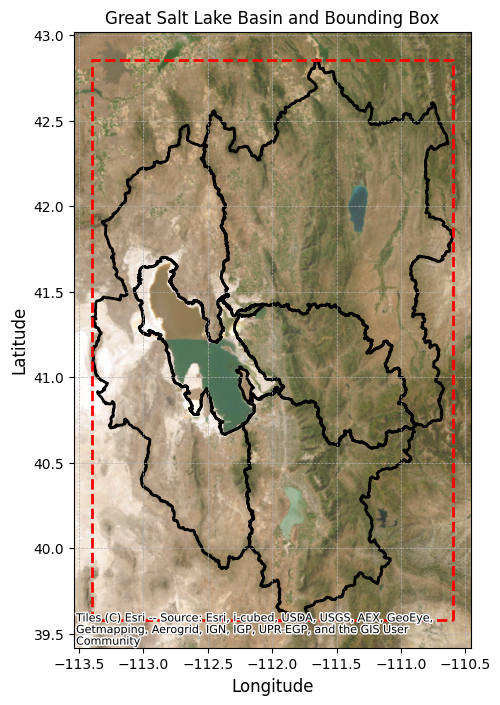

In [5]:
# Read the shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)

# Get the total bounds of the shapefile and display it
bounds = gdf.total_bounds

# Create a bounding box from the bounds
bbox = box(bounds[0], bounds[1], bounds[2], bounds[3])

# Convert the bounding box into a GeoDataFrame
bbox_gdf = gpd.GeoDataFrame([bbox], columns=['geometry'], crs=gdf.crs)

# Create a layout for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Display the shapefile
gdf.plot( ax=ax, color='none', edgecolor='black', linewidth=2)

# Plot the bounding box on the same plot (using the ax object from the previous plot)
bbox_gdf.boundary.plot(ax=ax, color="red", linestyle='--', linewidth=2)

# Add a topographic basemap using contextily 
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=gdf.crs.to_string(), alpha=0.8)

# Add title
ax.set_title("Great Salt Lake Basin and Bounding Box", fontsize=12)

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize x and y axis labels
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.show()

### 4. Virtually Load the Data Array 
This block of code maps the input variable and aggregation interval onto the variable encoding used in the Zarr bucket storage.  It then loads the virtual xarray dataset for the variable of interest. 

In [6]:
# Get the variable code
variable_code = get_variable_code(variable_name)

# Get the S3 bucket data file URL
url = get_conus_bucket_url(variable_code)
ds = load_dataset(url)

# Print the unit of the slected variable in AORC dataset
print(f"The unit of {list(ds.data_vars)[0]} is {ds[list(ds.data_vars)[0]].attrs.get('units', 'No units specified')}")

# Print the dataset (ds) of selected variable
ds

The unit of RAINRATE is mm s^-1


<xarray.Dataset> Size: 27TB
Dimensions:   (time: 385704, y: 3840, x: 4608)
Coordinates:
  * time      (time) datetime64[ns] 3MB 1979-02-01 ... 2023-01-31T23:00:00
  * x         (x) float64 37kB -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y         (y) float64 31kB -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    RAINRATE  (time, y, x) float32 27TB ...
    crs       |S1 1B ...
Attributes:
    NWM_version_number:   v2.1
    model_configuration:  AORC
    model_output_type:    forcing

### 4. Subset and Aggregate the Data

The output is a dataframe with datetime in the first column, followed by values for the specified variable.

This block of code first projects the bounding box coordinates to the coordinate system used by the AORC data. The input coordinate system is from the geopandas data frame from the shapefile. The AORC data coordinate system is a Lambert Conformal Conic projection used by the National Water Model. Curious users could examine ds.crs.esri_pe_string to see details. 

Xarray functions are used to aggregate both in space and time. Xarray defaults are used, though other xarray options could be set if needed.  The time step of the input AORC data is hourly and spacing of the AORC data 1 km.

The results is saved in a data frame ds_subset.df which holds as columns time (date) and the variable of interest. 

In [7]:
%%time
# The above code line is for measuring code execution time for this cell

# Reproject coordinates
x_min, y_min = reproject_coordinates(ds, bounds[0], bounds[1], gdf.crs)
x_max, y_max = reproject_coordinates(ds, bounds[2], bounds[3], gdf.crs)

# Get the aggregation code from the aggregation interval
agg_code = get_aggregation_code(agg_interval)

# Subsetting and aggregating a user-defined variable
variable_code_cap = variable_code.upper()
if variable_code == 'precip':
    ds_subset = ds.sel(y=slice(y_min, y_max), x=slice(x_min, x_max)).loc[dict(time=slice(start_datetime,end_datetime))]
    df_subset = ds_subset['RAINRATE'].resample(time=agg_code).sum().mean(['x', 'y']).to_dataframe()*3600
else:
    ds_subset = ds.sel(y=slice(y_min, y_max), x=slice(x_min, x_max)).loc[dict(time=slice(start_datetime,end_datetime))]
    df_subset = ds_subset[variable_code_cap].resample(time=agg_code).mean().mean(['x', 'y']).to_dataframe()

df_subset

CPU times: user 1min 11s, sys: 33.4 s, total: 1min 45s
Wall time: 2min 37s


,RAINRATE
time,
2020-01-31,48.602524
2020-02-29,28.538752
2020-03-31,42.350037
2020-04-30,21.769846
2020-05-31,22.901434
2020-06-30,53.758411
2020-07-31,9.391751
2020-08-31,3.990829
2020-09-30,10.375813


### 5. Plot the Data

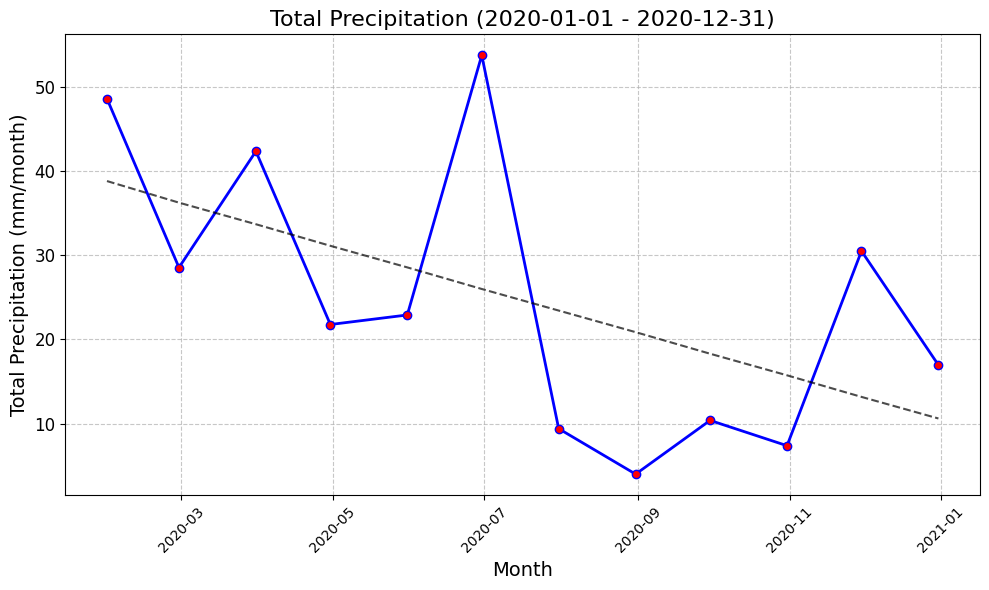

In [8]:
# Extracting the time index and column to plot
time_list=pd.to_datetime(df_subset.index)
data_list = df_subset.iloc[:,0]
    
# Setup the Plot
plt.figure(figsize=(10, 6))
plt.plot(time_list, data_list, color='blue', linewidth=2, marker='o', markersize=6, markerfacecolor='red', markeredgewidth=1)
plt.title(f'{variable_name} ({start_datetime[:]} - {end_datetime[:]})', fontsize=16)
plt.xlabel(f'{agg_interval.capitalize()}', fontsize=14)
plt.ylabel(f'{variable_name} (mm/{agg_interval})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

# Adding annotations or additional information if needed
# Example: adding a trend line
z = np.polyfit(range(len(time_list)), data_list, 1)
p = np.poly1d(z)
plt.plot(time_list, p(range(len(time_list))), color='black', linestyle='--', alpha=0.7)

# Saving the plot
plt.savefig(f'{agg_interval}_{variable_code}_plot_for_area.png', dpi=800)

# Displaying the plot
plt.show()

### 6. Save the Data as a CSV File

In [9]:
# Save the DataFrame to a CSV file

# Specify the file path where you want to save the CSV file
file_path = f"{variable_name}_over_box.csv"

# Save the DataFrame to a CSV file
df_subset.to_csv(file_path, index=True)  